In [1]:
import gempyor
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, sys
from pathlib import Path
import xarray as xr

folder = 'datasets/USA-20220923T15431/hosp/'
col2keep = ['incidI_FluA', 'incidI_FluB']

In [2]:
humid = pd.read_csv('datasets/USA-20220923T15431/r0s_ts_2022-2023.csv', index_col='date', parse_dates=True)

In [3]:
maxfiles = -1
hosp_files = list(Path(str(folder)).rglob('*.parquet'))[:maxfiles]
df = gempyor.read_df(str(hosp_files[0]))

# To be pasted later
indexes = df[['date', 'geoid']]
full_df = df[['date', 'geoid']] # to
geoids = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').columns)
dates = list(pd.concat([df[col2keep[0]], indexes], axis=1).pivot(values=col2keep[0], index='date', columns='geoid').index)

In [4]:
incid_xarr = xr.DataArray(-1 * np.ones((len(hosp_files), 
                           len(col2keep),
                           len(full_df.date.unique()),
                           len(full_df.geoid.unique())
                          )), 
                         coords={'sample': np.arange(len(hosp_files)),'feature': col2keep, 'date': dates, 'place': geoids}, 
                         dims=["sample", "feature", "date", "place"])


for i, path_str in enumerate(hosp_files):
    df = gempyor.read_df(str(path_str))
    data = df[col2keep]
    for k, c in enumerate(col2keep):
        incid_xarr.loc[dict(sample=i, feature=c)] = pd.concat([data[c], indexes], axis=1).pivot(values=c, index='date', columns='geoid').to_numpy()
        

    data.columns = [n+f'_{i}' for n in col2keep]   
    full_df = pd.concat([full_df, data], axis=1)
    

print(int((incid_xarr<0).sum()), f' errors on {i} files')

0  errors on 298 files


In [5]:
humid_st = np.dstack([humid.to_numpy()]*len(hosp_files))
#humid_st = humid_st[:, np.newaxis, :]
print(humid_st.shape)
covar_xarr = xr.DataArray(humid_st, 
                          coords={
                                  #'feature': ['R0Humidity'],
                                  'date': humid.index,
                                  'place': geoids,
                                  'sample': np.arange(len(hosp_files)),}, 
                          dims=[ "date", "place", "sample"]) #"feature",
covar_xarr = covar_xarr.expand_dims({"feature":['R0Humidity']})

(329, 51, 299)


## makes the dates of r0 and humidity match

In [6]:
print(type(incid_xarr), incid_xarr.date[0], incid_xarr.date[-1] )
print(type(covar_xarr), covar_xarr.date[0], covar_xarr.date[-1])

<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-24T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-24 <xarray.DataArray 'date' ()>
array('2023-08-05T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-08-05
<class 'xarray.core.dataarray.DataArray'> <xarray.DataArray 'date' ()>
array('2022-07-17T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2022-07-17 <xarray.DataArray 'date' ()>
array('2023-06-10T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    date     datetime64[ns] 2023-06-10


In [8]:
full_xarr = xr.concat([incid_xarr,covar_xarr], dim="feature", join="inner")

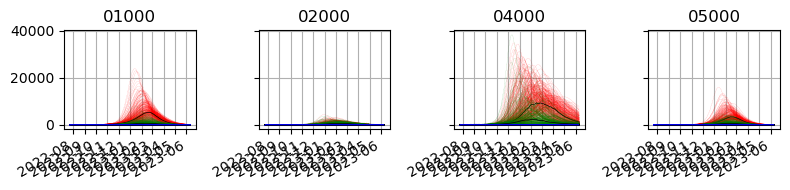

In [9]:
grid = (1,4)
fig, axes = plt.subplots(grid[0], grid[1], sharex=True, sharey=True, figsize=(grid[1]*2,grid[0]*2))
for i, ax in enumerate(axes.flat):
    c = ['red', 'green', 'blue']
    place = full_xarr.get_index('place')[i]
    tp = full_xarr.sel(place=place)
    for k, val in enumerate(full_xarr.feature):
        ax.plot(tp.date, tp.sel(feature=val).T, c = c[k], lw = .1, alpha=.5)
        ax.plot(tp.date, tp.sel(feature=val).T.median(axis=1), 
                c = 'k',#'dark'+c[k], 
                lw = .5, 
                alpha=1)
    ax.grid()
    ax.set_title(place)
fig.autofmt_xdate()
fig.tight_layout()

In [10]:
full_xarr_w = full_xarr.resample(date="W").sum()

In [12]:

full_xarr_w.to_netcdf('datasets/from_csp_weekly.nc')
full_xarr_w

<xarray.DataArray (sample: 299, feature: 3, date: 47, place: 51)>
array([[[[1.13123568e+00, 1.30596213e-04, 2.20269809e-03, ...,
          2.55962416e-03, 8.14536105e-04, 1.15485564e-04],
         [3.22713447e+00, 3.90305829e-03, 6.25985467e+00, ...,
          2.99299566e-01, 2.89770136e-02, 4.29121177e-03],
         [1.92615222e+00, 1.02148997e-02, 9.74413787e+01, ...,
          5.24638547e-01, 7.44809796e-02, 1.11283339e-02],
         ...,
         [9.45720984e+02, 1.36489844e+02, 7.65603727e+03, ...,
          2.25381760e+02, 1.29304028e+03, 1.48001741e+02],
         [5.64850938e+02, 8.37170692e+01, 6.42659422e+03, ...,
          1.21062714e+02, 6.47250776e+02, 8.82786822e+01],
         [2.88781234e+02, 4.56269359e+01, 4.58138648e+03, ...,
          5.50333615e+01, 2.76286403e+02, 4.49629239e+01]],

        [[4.52536649e-03, 4.57710809e-05, 2.69631947e-03, ...,
          9.24989706e-04, 3.38429562e+00, 8.97333782e+00],
         [1.26948887e-01, 2.70367774e-03, 8.33915881e-02, ...,
          5.74287395e+01, 8.46200144e+00, 2.14454205e+01],
         [6.63248115e-01, 2.80148623e+00, 4.98792444e+02, ...,
          2.78919226e+01, 3.00688792e+00, 1.54468932e+01],
...
         [1.30657553e+02, 1.02910951e+02, 3.01742245e+03, ...,
          8.45003783e+00, 6.10459941e+01, 1.53516737e+01],
         [7.68431934e+01, 7.20919662e+01, 2.55593916e+03, ...,
          4.69225546e+00, 3.55187310e+01, 1.63851546e+01],
         [4.32927146e+01, 4.67260782e+01, 1.83080789e+03, ...,
          2.45337231e+00, 2.06116223e+01, 1.41856474e+01]],

        [[1.29818589e+00, 8.84046265e-01, 8.92386507e-01, ...,
          1.04553332e+00, 9.28917436e-01, 1.20933000e+00],
         [9.09522734e+00, 6.19022749e+00, 6.25138528e+00, ...,
          7.32243452e+00, 6.50398711e+00, 8.52098397e+00],
         [9.15443745e+00, 6.19416716e+00, 6.26310392e+00, ...,
          7.33238501e+00, 6.52042182e+00, 8.66473164e+00],
         ...,
         [1.12684686e+01, 6.92289748e+00, 7.08810851e+00, ...,
          9.06771165e+00, 7.92671422e+00, 1.01696083e+01],
         [1.08090216e+01, 6.66751532e+00, 6.79995176e+00, ...,
          8.48082883e+00, 7.53150989e+00, 9.75008275e+00],
         [8.93078917e+00, 5.54814990e+00, 5.64114587e+00, ...,
          6.87926662e+00, 6.18742508e+00, 8.05758845e+00]]]])
Coordinates:
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 291 292 293 294 295 296 297 298
  * place    (place) <U5 '01000' '02000' '04000' ... '54000' '55000' '56000'
  * feature  (feature) object 'incidI_FluA' 'incidI_FluB' 'R0Humidity'
  * date     (date) datetime64[ns] 2022-07-24 2022-07-31 ... 2023-06-11

In [14]:
full_xarr_w_padded = full_xarr_w.pad({'date': (0, 17), 'place':(0,13)}, mode='constant', constant_values=0)
print(full_xarr_w_padded.shape)
full_xarr_w_padded.to_netcdf('datasets/from_csp_weekly_pad.nc')

(299, 3, 64, 64)


### Dengue Trial

In [ ]:
def yw2date(row):
    year = int(row["year"])
    week = int(row["week"])
    date = "{}-{}-1".format(year, week)
    return datetime.strptime(date, "%Y-%W-%w")
df = pd.read_csv('dengue-thailand-province-week.csv')
df['year'] = df['date_sick_year']
df = df.drop('date_sick_year', axis=1)
df['date'] = df.apply(yw2date, axis=1)

## Cannot pivot there are duplicated entries:
df1 = df.set_index(['year', 'week', 'province'])
duplicated = np.where(df1.index.duplicated())
print(len(duplicated[0]), "duplicated index entries...")
print(duplicated[0])
print(df1.iloc[116065])
print(df1.loc[1999, 1, 10])

# pivot_table with aggregrate as mean
df = df.pivot_table(index='date', columns='province', values='cases', aggfunc='mean') # perhaps should be sum
fig, axes = plt.subplots(11, 7, sharex=True, sharey=True, figsize=(10,10))
for i, prov in enumerate(df.columns):
    ax = axes.flat[i]
    ax.plot(df[prov])
    ax.grid()
    ax.set_title(prov)
fig.autofmt_xdate()
fig.tight_layout()